<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
Supplementary code for the <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a> book by <a href="https://sebastianraschka.com">Sebastian Raschka</a><br>
<br>Code repository: <a href="https://github.com/rasbt/LLMs-from-scratch">https://github.com/rasbt/LLMs-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://mng.bz/orYv"><img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/cover-small.webp" width="100px"></a>
</td>
</tr>
</table>

# 第6章：用于文本分类的微调

In [55]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        # "tensorflow", # For OpenAI's pretrained weights
        "pandas"      # Dataset loading
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.9.0
numpy version: 1.26.4
tiktoken version: 0.7.0
torch version: 2.3.1
pandas version: 2.2.2


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/chapter-overview.webp" width=500px>

## 6.1 不同类别的微调

- 本节没有代码

- 微调语言模型最常见的方法是指令微调和分类微调
- 如下所示的指令微调是下一章的主题

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/instructions.webp" width=500px>

- 本章的主题是分类微调，如果您有机器学习背景，您可能已经熟悉这个过程 -- 例如，它类似于训练卷积网络来对手写数字进行分类
- 在分类微调中，我们有模型可以输出的特定数量的类标签，例如“垃圾邮件”和“非垃圾邮件”
- 分类微调模型只能预测在训练期间看到的类别，例如“垃圾邮件”或“非垃圾邮件”，而指令微调模型通常可以执行许多任务
- 我们可以将分类微调模型视为非常专业的模型； 在实践中，创建专门的模型比创建在许多不同任务上表现良好的通用模型要容易得多

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/spam-non-spam.webp" width=500px>

## 6.2 准备数据集

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-1.webp" width=500px>

- 本节准备我们用于分类微调的数据集
- 我们使用包含垃圾邮件和非垃圾邮件文本序列消息的数据集来微调 LLM 以对它们进行分类
- 首先，我们下载并解压数据集

In [2]:
import urllib.request
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/static/public/228/sms+spam+collection.zip"
zip_path = "sms_spam_collection.zip"
extracted_path = "sms_spam_collection"
data_file_path = Path(extracted_path) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path):
    if data_file_path.exists():
        print(f"{data_file_path} already exists. Skipping download and extraction.")
        return

    # 下载文件
    with urllib.request.urlopen(url) as response:
        with open(zip_path, "wb") as out_file:
            out_file.write(response.read())

    # 解压文件
    with zipfile.ZipFile(zip_path, "r") as zip_ref:
        zip_ref.extractall(extracted_path)

    # 添加 .tsv 文件扩展
    original_file_path = Path(extracted_path) / "SMSSpamCollection"
    os.rename(original_file_path, data_file_path)
    print(f"File downloaded and saved as {data_file_path}")

download_and_unzip_spam_data(url, zip_path, extracted_path, data_file_path)

File downloaded and saved as sms_spam_collection\SMSSpamCollection.tsv


- 数据集保存为制表符分隔的文本序列文件，我们可以将其加载到 pandas DataFrame 中

In [3]:
import pandas as pd

df = pd.read_csv(data_file_path, sep="\t", header=None, names=["Label", "Text"])
df

,Label,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


- 当我们检查类别分布时，我们发现数据中包含“ham”（即“非垃圾邮件”）的频率比“垃圾邮件”的频率高得多

In [4]:
print(df["Label"].value_counts())

Label
ham     4825
spam     747
Name: count, dtype: int64


- 为简单起见，并且因为无论如何我们更喜欢用于教育目的的小数据集（这将使 LLM 更快地微调成为可能），我们对数据集进行了二次采样（欠采样），以便它包含每个类别的 747 个实例
- 除了欠采样之外，还有其他几种处理类平衡的方法，但它们超出了一本大模型书籍的范围；您可以在 [`imbalanced-learn` 用户指南](https://imbalanced-learn.org/stable/user_guide.html)中找到示例和更多信息

In [5]:
def create_balanced_dataset(df):
    
    # 计算"spam"实例的数量
    num_spam = df[df["Label"] == "spam"].shape[0]
    
    # 随机采样"ham"实例以匹配"spam"实例的数量
    ham_subset = df[df["Label"] == "ham"].sample(num_spam, random_state=123)
    
    # 将"ham"子集与"spam"结合起来
    balanced_df = pd.concat([ham_subset, df[df["Label"] == "spam"]])

    return balanced_df

balanced_df = create_balanced_dataset(df)
print(balanced_df["Label"].value_counts())

Label
ham     747
spam    747
Name: count, dtype: int64


- 接下来，我们将字符串类标签"ham"和"spam"更改为整数类标签0和1：

In [6]:
balanced_df["Label"] = balanced_df["Label"].map({"ham": 0, "spam": 1})

- 现在让我们定义一个函数，将数据集随机划分为训练、验证和测试子集

In [7]:
def random_split(df, train_frac, validation_frac):
    # 打乱整个 DataFrame
    df = df.sample(frac=1, random_state=123).reset_index(drop=True)

    # 计算切分索引
    train_end = int(len(df) * train_frac)
    validation_end = train_end + int(len(df) * validation_frac)

    # 切分 DataFrame
    train_df = df[:train_end]
    validation_df = df[train_end:validation_end]
    test_df = df[validation_end:]

    return train_df, validation_df, test_df

train_df, validation_df, test_df = random_split(balanced_df, 0.7, 0.1)
# 测试大小默认为 0.2

train_df.to_csv("train.csv", index=None)
validation_df.to_csv("validation.csv", index=None)
test_df.to_csv("test.csv", index=None)

## 6.3 创建数据加载器

- 请注意文本序列有不同的长度； 如果我们想在一批中组合多个训练示例，我们必须
   1. 将所有消息截断为数据集或批次中最短文本序列的长度
   2. 将所有消息填充到数据集或批次中最长文本序列的长度

- 我们选择选项 2，并将所有文本序列填充到数据集中最长的文本序列
- 为此，我们使用 `<|endoftext|>` 作为填充标记，如第 2 章所述

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/pad-input-sequences.webp?123" width=500px>

In [8]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


- 下面的`SpamDataset`类标识训练数据集中最长的序列，并将填充标记添加到其他序列中以匹配该序列长度

In [9]:
import torch
from torch.utils.data import Dataset


class SpamDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=None, pad_token_id=50256):
        self.data = pd.read_csv(csv_file)

        # 预标记文本
        self.encoded_texts = [
            tokenizer.encode(text) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()
        else:
            self.max_length = max_length
            # 如果序列长于 max_length，则截断序列
            self.encoded_texts = [
                encoded_text[:self.max_length]
                for encoded_text in self.encoded_texts
            ]

        # 将序列填充到最长序列
        self.encoded_texts = [
            encoded_text + [pad_token_id] * (self.max_length - len(encoded_text))
            for encoded_text in self.encoded_texts
        ]

    def __getitem__(self, index):
        encoded = self.encoded_texts[index]
        label = self.data.iloc[index]["Label"]
        return (
            torch.tensor(encoded, dtype=torch.long),
            torch.tensor(label, dtype=torch.long)
        )

    def __len__(self):
        return len(self.data)

    def _longest_encoded_length(self):
        max_length = 0
        for encoded_text in self.encoded_texts:
            encoded_length = len(encoded_text)
            if encoded_length > max_length:
                max_length = encoded_length
        return max_length

In [10]:
train_dataset = SpamDataset(
    csv_file="train.csv",
    max_length=None,
    tokenizer=tokenizer
)

print(train_dataset.max_length)

120


- 我们还将验证和测试集填充到最长的训练序列
- 请注意，比最长训练示例更长的验证和测试集样本将通过`SpamDataset`代码中的`encoded_text[:self.max_length]`被截断
- 此行为完全是可选的，如果我们在验证集和测试集案例中设置`max_length=None`，它也会很好地工作

In [11]:
val_dataset = SpamDataset(
    csv_file="validation.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)
test_dataset = SpamDataset(
    csv_file="test.csv",
    max_length=train_dataset.max_length,
    tokenizer=tokenizer
)

- 接下来，我们使用数据集来实例化数据加载器，这与前面章节中创建数据加载器类似

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/batch.webp" width=500px>

In [12]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    drop_last=True,
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    drop_last=False,
)

- 作为验证步骤，我们迭代数据加载器并确保每个批次包含 8 个训练示例，其中每个训练示例包含 120 个标记

In [13]:
print("Train loader:")
for input_batch, target_batch in train_loader:
    pass

print("Input batch dimensions:", input_batch.shape)
print("Label batch dimensions", target_batch.shape)

Train loader:
Input batch dimensions: torch.Size([8, 120])
Label batch dimensions torch.Size([8])


- 最后，让我们打印每个数据集中的批次总数

In [14]:
print(f"{len(train_loader)} training batches")
print(f"{len(val_loader)} validation batches")
print(f"{len(test_loader)} test batches")

130 training batches
19 validation batches
38 test batches


## 6.4 使用预训练权重初始化模型

- 在本节中，我们初始化上一章中使用的预训练模型

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-2.webp" width=500px>

In [15]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves"

BASE_CONFIG = {
    "vocab_size": 50257,     # Vocabulary size
    "context_length": 1024,  # Context length
    "drop_rate": 0.0,        # Dropout rate
    "qkv_bias": True         # Query-key-value bias
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

In [16]:
from transformers import GPT2Model


# allowed model names
model_names = {
    "gpt2-small": "openai-community/gpt2",         # 124M
    "gpt2-medium": "openai-community/gpt2-medium", # 355M
    "gpt2-large": "openai-community/gpt2-large",   # 774M
    "gpt2-xl": "openai-community/gpt2-xl"          # 1558M
}

CHOOSE_MODEL = "gpt2-small"

gpt_hf = GPT2Model.from_pretrained(model_names[CHOOSE_MODEL], cache_dir="../../checkpoints")
gpt_hf.eval()

GPT2Model(
  (wte): Embedding(50257, 768)
  (wpe): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (h): ModuleList(
    (0-11): 12 x GPT2Block(
      (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (attn): GPT2Attention(
        (c_attn): Conv1D()
        (c_proj): Conv1D()
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (mlp): GPT2MLP(
        (c_fc): Conv1D()
        (c_proj): Conv1D()
        (act): NewGELUActivation()
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
)

In [49]:
import numpy as np

def assign_check(left, right):
    if left.shape != right.shape:
        raise ValueError(f"Shape mismatch. Left: {left.shape}, Right: {right.shape}")
    # return torch.nn.Parameter(torch.tensor(right))
    return torch.nn.Parameter(right.clone().detach())

def load_weights(gpt, gpt_hf):

    d = gpt_hf.state_dict()

    gpt.pos_emb.weight = assign_check(gpt.pos_emb.weight, d["wpe.weight"])
    gpt.tok_emb.weight = assign_check(gpt.tok_emb.weight, d["wte.weight"])
    
    for b in range(BASE_CONFIG["n_layers"]):
        q_w, k_w, v_w = np.split(d[f"h.{b}.attn.c_attn.weight"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign_check(gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign_check(gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign_check(gpt.trf_blocks[b].att.W_value.weight, v_w.T)
    
        q_b, k_b, v_b = np.split(d[f"h.{b}.attn.c_attn.bias"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign_check(gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign_check(gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign_check(gpt.trf_blocks[b].att.W_value.bias, v_b)
    
    
        gpt.trf_blocks[b].att.out_proj.weight = assign_check(gpt.trf_blocks[b].att.out_proj.weight, d[f"h.{b}.attn.c_proj.weight"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign_check(gpt.trf_blocks[b].att.out_proj.bias, d[f"h.{b}.attn.c_proj.bias"])
    
        gpt.trf_blocks[b].ff.layers[0].weight = assign_check(gpt.trf_blocks[b].ff.layers[0].weight, d[f"h.{b}.mlp.c_fc.weight"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign_check(gpt.trf_blocks[b].ff.layers[0].bias, d[f"h.{b}.mlp.c_fc.bias"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign_check(gpt.trf_blocks[b].ff.layers[2].weight, d[f"h.{b}.mlp.c_proj.weight"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign_check(gpt.trf_blocks[b].ff.layers[2].bias, d[f"h.{b}.mlp.c_proj.bias"])
    
        gpt.trf_blocks[b].norm1.scale = assign_check(gpt.trf_blocks[b].norm1.scale, d[f"h.{b}.ln_1.weight"])
        gpt.trf_blocks[b].norm1.shift = assign_check(gpt.trf_blocks[b].norm1.shift, d[f"h.{b}.ln_1.bias"])
        gpt.trf_blocks[b].norm2.scale = assign_check(gpt.trf_blocks[b].norm2.scale, d[f"h.{b}.ln_2.weight"])
        gpt.trf_blocks[b].norm2.shift = assign_check(gpt.trf_blocks[b].norm2.shift, d[f"h.{b}.ln_2.bias"])
    
        gpt.final_norm.scale = assign_check(gpt.final_norm.scale, d[f"ln_f.weight"])
        gpt.final_norm.shift = assign_check(gpt.final_norm.shift, d[f"ln_f.bias"])
        gpt.out_head.weight = assign_check(gpt.out_head.weight, d["wte.weight"])




In [50]:
import torch
from previous_chapters import GPTModel
model = GPTModel(BASE_CONFIG)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_weights(model, gpt_hf)
model.to(device)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 为了确保模型加载正确，让我们仔细检查它是否生成连贯的文本。

In [51]:
from previous_chapters import (
    generate_text_simple,
    text_to_token_ids,
    token_ids_to_text
)


text_1 = "Every effort moves you"

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_1, tokenizer),
    max_new_tokens=15,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Every effort moves you forward.

The first step is to understand the importance of your work


- 在我们将模型微调为分类器之前，让我们看看模型是否已经可以通过提示对垃圾邮件进行分类。

In [52]:
text_2 = (
    "Is the following text 'spam'? Answer with 'yes' or 'no':"
    " 'You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award.'"
    " Answer with 'yes' or 'no'."
)

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(text_2, tokenizer),
    max_new_tokens=23,
    context_size=BASE_CONFIG["context_length"]
)

print(token_ids_to_text(token_ids, tokenizer))

Is the following text 'spam'? Answer with 'yes' or 'no': 'You are a winner you have been specially selected to receive $1000 cash or a $2000 award.' Answer with 'yes' or 'no'. Answer with 'yes' or 'no'. Answer with 'yes' or 'no'. Answer with 'yes'


- 正如我们所看到的，该模型不太擅长遵循指令
- 这是预料之中的，因为它只经过了预训练，没有进行指令微调（指令微调将在下一章中介绍）

## 6.5 添加分类头

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/lm-head.webp" width=500px>

- 在本节中，我们正在修改预训练的 LLM，使其为分类微调做好准备
- 我们先看一下模型架构

In [53]:
print(model)

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_resid): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768,

- 综上所述，我们可以看到我们在第 4 章中实现的模型架构
- 我们的目标是替换和微调输出层
- 为了实现这一目标，我们首先冻结模型，这意味着我们使所有层都不可训练

In [22]:
for param in model.parameters():
    param.requires_grad = False

- 然后，我们替换输出层（`model.out_head`），该层最初将层输入映射到 50,257 维（词汇表的大小）
- 由于我们对二元分类模型进行了微调（预测 2 个类别，"spam" 和 "not spam"），因此我们可以如下所示替换输出层，默认情况下该输出层是可训练的
- 请注意，我们使用 `BASE_CONFIG["emb_dim"]` （在 `"gpt2-small (124M)"` 模型中等于 768）以使下面的代码更通用

In [23]:
torch.manual_seed(123)

num_classes = 2
model.out_head = torch.nn.Linear(in_features=BASE_CONFIG["emb_dim"], out_features=num_classes)

- 从技术上讲，仅训练输出层就足够了
- 然而，正如我在[实验微调附加层](https://magazine.sebastianraschka.com/p/finetuning-large-language-models)中发现可以显着提高性能
- 因此，我们还使最后一个transformer块和将最后一个transformer块连接到输出层的最终`LayerNorm`模块可训练

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/trainable.webp" width=500px>

In [24]:
for param in model.trf_blocks[-1].parameters():
    param.requires_grad = True

for param in model.final_norm.parameters():
    param.requires_grad = True

- 我们仍然可以像之前的章节一样使用这个模型
- 例如，让我们为其提供一些文本输入

In [25]:
inputs = tokenizer.encode("Do you have time")
inputs = torch.tensor(inputs).unsqueeze(0)
print("Inputs:", inputs)
print("Inputs dimensions:", inputs.shape) # shape: (batch_size, num_tokens)

Inputs: tensor([[5211,  345,  423,  640]])
Inputs dimensions: torch.Size([1, 4])


- 与前几章不同的是，它现在有两个输出维度，而不是 50,257

In [26]:
with torch.no_grad():
    outputs = model(inputs)

print("Outputs:\n", outputs)
print("Outputs dimensions:", outputs.shape) # 形状: (batch_size, num_tokens, num_classes)

Outputs:
 tensor([[[-1.5854,  0.9904],
         [-3.7235,  7.4548],
         [-2.2661,  6.6049],
         [-3.5983,  3.9902]]])
Outputs dimensions: torch.Size([1, 4, 2])


- 如前几章所述，对于每个输入标记，都有一个输出向量
- 由于我们向模型提供了具有 4 个输入标记的文本样本，因此输出由上面的 4 个二维输出向量组成

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/input-and-output.webp" width=500px>

- 在第 3 章中，我们讨论了注意力机制，它将每个输入标记连接到另一个输入标记
- 在第 3 章中，我们还介绍了类 GPT 模型中使用的因果注意力掩模； 这个因果掩码让当前标记只关注当前和之前的标记位置
- 基于这种因果注意机制，第四个（最后一个）标记包含所有标记中最多的信息，因为它是唯一包含所有其他标记信息的标记
- 因此，我们对最后一个标记特别感兴趣，我们将针对垃圾邮件分类任务对其进行微调

In [27]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/attention-mask.webp" width=200px>

## 6.6 计算分类损失和准确率

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-3.webp?123" width=500px>

- 在解释损失计算之前，我们先简单看一下模型输出是如何转化为类标签的

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/class-argmax.webp" width=600px>

In [28]:
print("Last output token:", outputs[:, -1, :])

Last output token: tensor([[-3.5983,  3.9902]])


- 与第5章类似，我们通过`softmax` 函数将输出（logits）转换为概率分数，然后通过`argmax` 函数获得最大概率值的索引位置

In [29]:
probas = torch.softmax(outputs[:, -1, :], dim=-1)
label = torch.argmax(probas)
print("Class label:", label.item())

Class label: 1


- 请注意，softmax 函数在这里是可选的，如第 5 章所述，因为最大的输出对应于最大的概率分数

In [30]:
logits = outputs[:, -1, :]
label = torch.argmax(logits)
print("Class label:", label.item())

Class label: 1


- 我们可以应用这个概念来计算所谓的分类准确性，即计算给定数据集中正确预测的百分比
- 为了计算分类准确率，我们可以将前面基于`argmax`的预测代码应用于数据集中的所有示例，并计算正确预测的比例，如下所示：

In [31]:
def calc_accuracy_loader(data_loader, model, device, num_batches=None):
    model.eval()
    correct_predictions, num_examples = 0, 0

    if num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            input_batch, target_batch = input_batch.to(device), target_batch.to(device)

            with torch.no_grad():
                logits = model(input_batch)[:, -1, :]  # 最后输出标记的 Logits
            predicted_labels = torch.argmax(logits, dim=-1)

            num_examples += predicted_labels.shape[0]
            correct_predictions += (predicted_labels == target_batch).sum().item()
        else:
            break
    return correct_predictions / num_examples

- 让我们应用该函数来计算不同数据集的分类准确率：

In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # nn.Module 类不需要分配 model = model.to(device)

torch.manual_seed(123) # For reproducibility due to the shuffling in the training data loader

train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=10)
val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=10)
test_accuracy = calc_accuracy_loader(test_loader, model, device, num_batches=10)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 46.25%
Validation accuracy: 45.00%
Test accuracy: 48.75%


- 正如我们所看到的，预测准确率不是很好，因为我们还没有对模型进行微调

- 在开始微调（/训练）之前，我们首先必须定义训练期间要优化的损失函数
- 目标是最大化模型的垃圾邮件分类准确率； 然而，分类准确率不是一个可微函数
- 因此，我们最小化交叉熵损失作为最大化分类准确率的代理（您可以在我免费提供的[深度学习简介](https://sebastianraschka.com/blog/2021/dl-course.html#l08-multinomial-logistic-regression--softmax-regression)）的第8讲中了解有关此主题的更多信息
- `calc_loss_batch` 函数与第 5 章中的相同，只是我们只对优化最后一个标记 `model(input_batch)[:, -1, :]` 而不是所有标记 `model(input_batch)` 感兴趣

In [33]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)[:, -1, :]  # 最后输出标记的 Logits
    loss = torch.nn.functional.cross_entropy(logits, target_batch)
    return loss

`calc_loss_loader` 与第 5 章中的完全相同

In [34]:
# Same as in chapter 5
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # 如果 num_batches 超过数据加载器中的批次数，则减少批次数以匹配数据加载器中的批次总数
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- 使用`calc_closs_loader`，我们在开始训练之前计算初始训练、验证和测试集损失

In [35]:
with torch.no_grad(): # 禁用梯度跟踪以提高效率，因为我们还没有进行训练
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)
    test_loss = calc_loss_loader(test_loader, model, device, num_batches=5)

print(f"Training loss: {train_loss:.3f}")
print(f"Validation loss: {val_loss:.3f}")
print(f"Test loss: {test_loss:.3f}")

Training loss: 2.453
Validation loss: 2.583
Test loss: 2.322


- 在下一节中，我们训练模型以提高损失值，从而提高分类准确性

## 6.7 根据监督数据微调模型

- 在本节中，我们定义并使用训练函数来提高模型的分类准确率
- 下面的`train_classifier_simple`函数实际上与我们在第 5 章中用于预训练模型的`train_model_simple`函数相同
- 唯一的两个区别是我们现在
   1. 跟踪看到的训练示例的数量（`examples_seen`）而不是看到的示例的数量
   2. 计算每个时期后的准确率，而不是在每个时期后打印示例文本

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/training-loop.webp" width=500px>

In [36]:
# 总体与第 5 章中的 `train_model_simple` 相同
def train_classifier_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                            eval_freq, eval_iter, tokenizer):
    # 初始化列表以跟踪损失和看到的示例
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    examples_seen, global_step = 0, -1

    # 主要的训练循环
    for epoch in range(num_epochs):
        model.train()  # 将模型设置为训练模式

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 重置上一个 epoch 的损失梯度
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 计算损失梯度
            optimizer.step() # 使用损失梯度更新模型权重
            examples_seen += input_batch.shape[0] # 新功能：跟踪示例而不是标记
            global_step += 1

            # 可选的评估步骤
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # 计算每个 epoch 后的准确率
        train_accuracy = calc_accuracy_loader(train_loader, model, device, num_batches=eval_iter)
        val_accuracy = calc_accuracy_loader(val_loader, model, device, num_batches=eval_iter)
        print(f"Training accuracy: {train_accuracy*100:.2f}% | ", end="")
        print(f"Validation accuracy: {val_accuracy*100:.2f}%")
        train_accs.append(train_accuracy)
        val_accs.append(val_accuracy)

    return train_losses, val_losses, train_accs, val_accs, examples_seen

- `train_classifier_simple` 中使用的 `evaluate_model` 函数与我们在第 5 章中使用的函数相同

In [37]:
# Same as chapter 5
def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

- 在 M3 MacBook Air 笔记本电脑上训练大约需要 5 分钟，在 V100 或 A100 GPU 上训练不到半分钟

In [38]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.1)

num_epochs = 5
train_losses, val_losses, train_accs, val_accs, examples_seen = train_classifier_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=50, eval_iter=5,
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 2.153, Val loss 2.392
Ep 1 (Step 000050): Train loss 0.617, Val loss 0.637
Ep 1 (Step 000100): Train loss 0.523, Val loss 0.557
Training accuracy: 70.00% | Validation accuracy: 72.50%
Ep 2 (Step 000150): Train loss 0.561, Val loss 0.489
Ep 2 (Step 000200): Train loss 0.419, Val loss 0.397
Ep 2 (Step 000250): Train loss 0.409, Val loss 0.353
Training accuracy: 82.50% | Validation accuracy: 85.00%
Ep 3 (Step 000300): Train loss 0.333, Val loss 0.320
Ep 3 (Step 000350): Train loss 0.340, Val loss 0.306
Training accuracy: 90.00% | Validation accuracy: 90.00%
Ep 4 (Step 000400): Train loss 0.136, Val loss 0.200
Ep 4 (Step 000450): Train loss 0.153, Val loss 0.132
Ep 4 (Step 000500): Train loss 0.222, Val loss 0.137
Training accuracy: 100.00% | Validation accuracy: 97.50%
Ep 5 (Step 000550): Train loss 0.207, Val loss 0.143
Ep 5 (Step 000600): Train loss 0.083, Val loss 0.074
Training accuracy: 100.00% | Validation accuracy: 97.50%
Training completed in 14.25 m

- 与第 5 章类似，我们使用 matplotlib 绘制训练集和验证集的损失函数

In [39]:
import matplotlib.pyplot as plt

def plot_values(epochs_seen, examples_seen, train_values, val_values, label="loss"):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 绘制针对 epoch 的训练和验证损失
    ax1.plot(epochs_seen, train_values, label=f"Training {label}")
    ax1.plot(epochs_seen, val_values, linestyle="-.", label=f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    # 为所见示例创建第二个 x 轴
    ax2 = ax1.twiny()  # 创建共享相同 y 轴的第二个 x 轴
    ax2.plot(examples_seen, train_values, alpha=0)  # 用于对齐刻度的不可见图
    ax2.set_xlabel("Examples seen")

    fig.tight_layout()  # 调整布局以腾出空间
    plt.savefig(f"{label}-plot.pdf")
    plt.show()

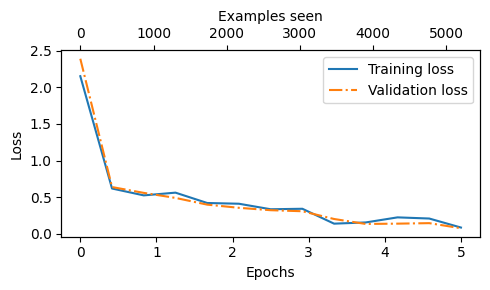

In [40]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_losses))

plot_values(epochs_tensor, examples_seen_tensor, train_losses, val_losses)

- 综上所述，根据向下的斜率，我们看到模型学习得很好
- 此外，训练和验证损失非常接近这一事实表明模型不会过度拟合训练数据
- 同样，我们可以绘制下面的准确率

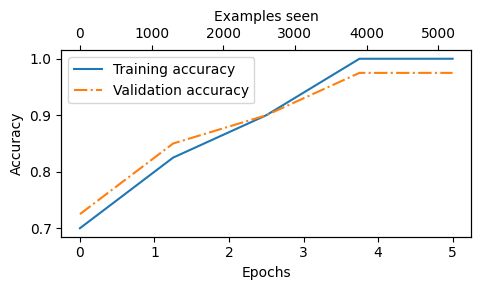

In [41]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_accs))
examples_seen_tensor = torch.linspace(0, examples_seen, len(train_accs))

plot_values(epochs_tensor, examples_seen_tensor, train_accs, val_accs, label="accuracy")

- 根据上面的准确率图，我们可以看到模型在第 4 轮和第 5 轮之后实现了相对较高的训练和验证准确度
- 但是，我们必须记住，我们之前在训练函数中指定了 `eval_iter=5`，这意味着我们只估计了训练集和验证集的性能
- 我们可以计算整个数据集的训练、验证和测试集性能，如下所示

In [42]:
train_accuracy = calc_accuracy_loader(train_loader, model, device)
val_accuracy = calc_accuracy_loader(val_loader, model, device)
test_accuracy = calc_accuracy_loader(test_loader, model, device)

print(f"Training accuracy: {train_accuracy*100:.2f}%")
print(f"Validation accuracy: {val_accuracy*100:.2f}%")
print(f"Test accuracy: {test_accuracy*100:.2f}%")

Training accuracy: 97.21%
Validation accuracy: 97.32%
Test accuracy: 95.67%


- 我们可以看到训练集和测试集的性能几乎相同
- 然而，基于稍低的测试集性能，我们可以看到模型在很小程度上过度拟合了训练数据，以及用于调整一些超参数（例如学习率）的验证数据
- 然而，这是正常的，通过增加模型的 dropout 率 (`drop_rate`) 或优化器设置中的 `weight_decay` 可能会进一步缩小这种差距

## 6.8 使用大模型作为垃圾邮件分类器

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch06_compressed/overview-4.webp" width=500px>

- 最后，让我们实际使用经过微调的 GPT 模型
- 下面的 `classify_review` 函数实现了与我们之前实现的 `SpamDataset` 类似的数据预处理步骤
- 然后，该函数从模型中返回预测的整数类标签，并返回相应的类别名称

In [43]:
def classify_review(text, model, tokenizer, device, max_length=None, pad_token_id=50256):
    model.eval()

    # 准备模型的输入
    input_ids = tokenizer.encode(text)
    supported_context_length = model.pos_emb.weight.shape[1]

    # 如果序列太长则截断
    input_ids = input_ids[:min(max_length, supported_context_length)]

    # 将序列填充到最长序列
    input_ids += [pad_token_id] * (max_length - len(input_ids))
    input_tensor = torch.tensor(input_ids, device=device).unsqueeze(0) # 添加批次维度

    # 模型推理
    with torch.no_grad():
        logits = model(input_tensor)[:, -1, :]  # 最后一个输出 token 的 Logits
    predicted_label = torch.argmax(logits, dim=-1).item()

    # 返回分类结果
    return "spam" if predicted_label == 1 else "not spam"

- 让我们尝试下面的几个例子

In [44]:
text_1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print(classify_review(
    text_1, model, tokenizer, device, max_length=train_dataset.max_length
))

spam


In [45]:
text_2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(classify_review(
    text_2, model, tokenizer, device, max_length=train_dataset.max_length
))

not spam


- 最后，让我们保存模型，以便以后我们想重用该模型而不必再次训练它

In [46]:
torch.save(model.state_dict(), "review_classifier.pth")

- 然后，在新会话中，我们可以按如下方式加载模型

In [47]:
model_state_dict = torch.load("review_classifier.pth")
model.load_state_dict(model_state_dict)

<All keys matched successfully>

## 总结和要点

- 有兴趣的读者可以在附录 E 中找到有关低秩适应（LoRA）的参数高效训练的介绍